In [1]:
# Import required libraries
import os
import sys
import torch
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# Add project root to path for imports
project_root = os.path.abspath('.')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import project modules from new structure
from configs.config import Config
from src.utils.data_utils import (
    load_triplet_csv, 
    TripletSignLanguageDataset, 
    create_triplet_data_loaders,
)
from src.utils.model_utils import (
    create_adjacency_matrix,
    create_model,
    create_triplet_model,
    load_model
)
from src.models.model import (
    HGC_LSTM
)
from src.models.triplet import (
    TripletNet
)
from src.utils.train_utils import (
    train_model_triplet
)
from src.utils.visualization_utils import (
    visualize_training_process,
    analyze_model_performance
)

print("✅ All modules imported successfully!")
print(f"📦 Project structure reorganized with modular imports")
print(f"🐍 Python: {sys.version}")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🔧 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🔧 CUDA Device: {torch.cuda.get_device_name(0)}")
print()

# Initialize configuration
config = Config()
print("🔧 Configuration loaded from configs/config.py")
print(f"📊 Data from: {config.data.input_kp_path}")
print(f"💾 Models save to: {config.model.checkpoint_dir}")
print(f"📈 Plots save to: {config.output.plots_dir}")

✅ All modules imported successfully!
📦 Project structure reorganized with modular imports
🐍 Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
🔥 PyTorch: 2.7.0+cu126
🔧 CUDA Available: True
🔧 CUDA Device: NVIDIA GeForce RTX 3070 Ti

🔧 Configuration loaded from configs/config.py
📊 Data from: dataset/Keypoints
💾 Models save to: outputs/models
📈 Plots save to: outputs/plots


In [2]:
# Import data utilities
from src.utils.data_utils import load_labels_from_csv

# Load labels
triplet_data = load_triplet_csv(None, config)
triplet_data

[(10, '10_02', '10_06', '15_05'),
 (8, '8_01', '8_20', '10_19'),
 (1, '1_11', '1_20', '2_01'),
 (15, '15_07', '15_16', '4_15'),
 (8, '8_02', '8_04', '11_03'),
 (10, '10_01', '10_16', '14_20'),
 (10, '10_13', '10_19', '15_13'),
 (5, '5_11', '5_19', '1_07'),
 (14, '14_02', '14_19', '9_07'),
 (7, '7_07', '7_14', '9_18'),
 (10, '10_08', '10_11', '6_19'),
 (4, '4_12', '4_17', '14_06'),
 (14, '14_02', '14_17', '4_17'),
 (11, '11_16', '11_18', '8_02'),
 (2, '2_02', '2_16', '11_05'),
 (2, '2_07', '2_12', '7_08'),
 (13, '13_02', '13_18', '10_12'),
 (8, '8_04', '8_14', '7_19'),
 (12, '12_13', '12_16', '8_11'),
 (2, '2_03', '2_06', '5_19'),
 (15, '15_18', '15_19', '3_07'),
 (2, '2_07', '2_09', '10_06'),
 (12, '12_07', '12_14', '1_19'),
 (8, '8_14', '8_18', '12_09'),
 (4, '4_02', '4_06', '3_06'),
 (12, '12_14', '12_17', '15_05'),
 (1, '1_01', '1_17', '8_06'),
 (3, '3_08', '3_14', '8_03'),
 (15, '15_04', '15_17', '9_06'),
 (11, '11_16', '11_20', '4_05'),
 (3, '3_12', '3_20', '11_10'),
 (11, '11_06'

In [3]:
# Create datasets with stratified split and augmentation
print("[INFO] Creating datasets...")
keypoints_dir = config.data.keypoints_output_dir

# Set random seed for reproducible splits
np.random.seed(42)

# Get parameters from config
use_strategy = config.data.use_strategy


# Training uses augmentation, validation does not (for fair evaluation)
train_augmentations = getattr(config.data, 'augmentations', [])
val_augmentations = [] 

print(f"Configuration:")
print(f"   Split strategy: {'Stratified' if use_strategy else 'Random'}")
print(f"   Train augmentations: {train_augmentations if train_augmentations else 'None'}")
print(f"   Val augmentations: {val_augmentations if val_augmentations else 'None (for fair evaluation)'}")
if 'translation' in train_augmentations:
    print(f"   Translation range: ±{config.data.translation_range}")
if 'scaling' in train_augmentations:
    print(f"   Scale range: ±{config.data.scale_range}")

train_dataset = TripletSignLanguageDataset(
    keypoints_dir, triplet_data, config,
    split_type='train', 
    augmentations=train_augmentations,
    use_strategy=use_strategy
)

val_dataset = TripletSignLanguageDataset(
    keypoints_dir, triplet_data, config,
    split_type='val', 
    augmentations=val_augmentations,
    use_strategy=use_strategy
)

[INFO] Creating datasets...
Configuration:
   Split strategy: Stratified
   Train augmentations: ['translation', 'scaling']
   Val augmentations: None (for fair evaluation)
   Translation range: ±0.1
   Scale range: ±0.1
 Augmentations: ['translation', 'scaling'] → 4 combinations
 Augmentations: [] → 1 combinations


In [4]:
print("\n[INFO] Creating data loaders...")
train_loader, val_loader = create_triplet_data_loaders(train_dataset, val_dataset, config)


[INFO] Creating data loaders...
 Triplet Train batches: 81
 Triplet Valid batches: 3
 Batch size: 128
 Data Augmentation (translation + scaling): 2565 original → 10260 total samples
 Augmentation combinations: ['original', 'translation', 'scaling', 'translation+scaling']
 Sample anchor shape:   torch.Size([128, 60, 75, 2])
 Sample positive shape: torch.Size([128, 60, 75, 2])
 Sample negative shape: torch.Size([128, 60, 75, 2])
 Sample anchor shape:   torch.Size([128, 60, 75, 2])
 Sample positive shape: torch.Size([128, 60, 75, 2])
 Sample negative shape: torch.Size([128, 60, 75, 2])


In [5]:
# Import model utilities
from src.utils.model_utils import create_adjacency_matrix

A = create_adjacency_matrix(config)
print(f"[INFO] Adjacency matrix shape: {A.shape}")
print(f"[INFO] Number of vertices: {config.hgc_lstm.num_vertices}")

[INFO] Adjacency matrix shape: torch.Size([75, 75])
[INFO] Number of vertices: 75


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_triplet_model(config)

In [7]:
print("[INFO] Starting training...")
print(f"[INFO] Training configuration:")
print(f"  - Epochs: {config.training.num_epochs}")
print(f"  - Batch size: {config.training.batch_size}")
print(f"  - Learning rate: {config.training.learning_rate}")
print(f"  - Optimizer: {config.training.optimizer}")
print(f"  - Scheduler: {config.training.scheduler}")
print(f"  - Early stopping patience: {config.training.early_stopping_patience}")
history = train_model_triplet(model, train_loader, val_loader, config, device)

[INFO] Starting training...
[INFO] Training configuration:
  - Epochs: 300
  - Batch size: 128
  - Learning rate: 0.001
  - Optimizer: adam
  - Scheduler: step
  - Early stopping patience: 50
Epoch 001/300 | Train Loss: 0.7947 | Val Loss: 0.3789 | LR: 0.00100000
Epoch 002/300 | Train Loss: 0.4758 | Val Loss: 0.3319 | LR: 0.00100000
Epoch 003/300 | Train Loss: 0.4132 | Val Loss: 0.1874 | LR: 0.00100000
Epoch 004/300 | Train Loss: 0.3452 | Val Loss: 0.2547 | LR: 0.00100000
Epoch 005/300 | Train Loss: 0.3095 | Val Loss: 0.1367 | LR: 0.00100000
Epoch 006/300 | Train Loss: 0.2405 | Val Loss: 0.1335 | LR: 0.00100000
Epoch 007/300 | Train Loss: 0.2242 | Val Loss: 0.0963 | LR: 0.00100000
Epoch 008/300 | Train Loss: 0.1771 | Val Loss: 0.0651 | LR: 0.00100000
Epoch 009/300 | Train Loss: 0.1654 | Val Loss: 0.0801 | LR: 0.00100000
Epoch 010/300 | Train Loss: 0.1256 | Val Loss: 0.0563 | LR: 0.00100000
Epoch 011/300 | Train Loss: 0.1338 | Val Loss: 0.0498 | LR: 0.00100000
Epoch 012/300 | Train Loss:

# Training Process Visualization

This section provides essential visualization of the training process including:
- **Loss curves**: Training and validation loss over epochs
- **Accuracy curves**: Training and validation accuracy over epochs  
- **Confusion matrix**: Model performance analysis on validation set

[INFO] Generating training process visualization...
Training curves saved to: training_plots/training_curves.png
Training curves saved to: training_plots/training_curves.png


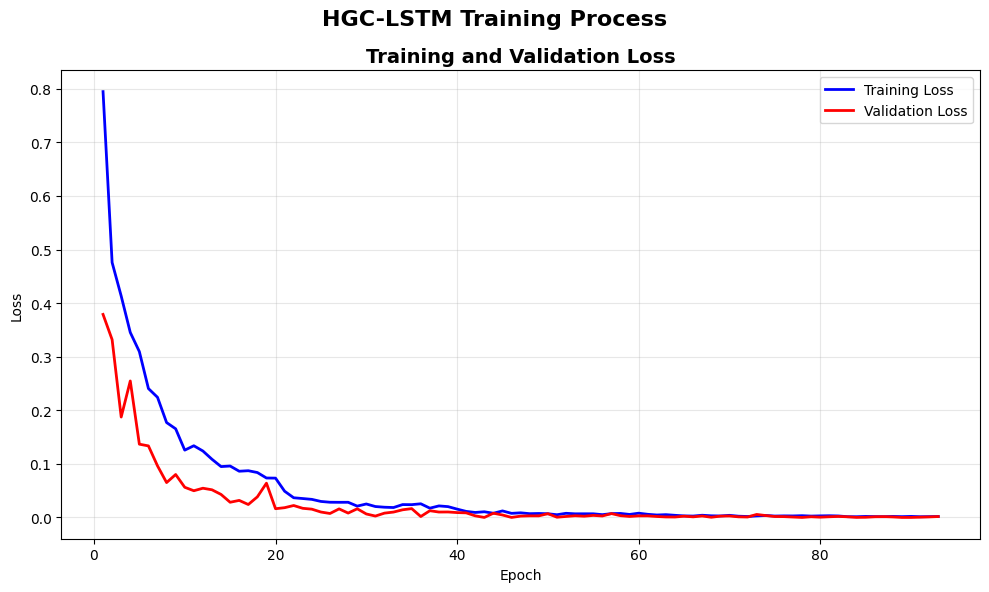

In [8]:
# Import visualization utilities
from src.utils.visualization_utils import visualize_training_triplet_process

# Visualize training process
print("[INFO] Generating training process visualization...")
training_fig = visualize_training_triplet_process(history, config, save_plots=True)

In [9]:
from src.utils.model_utils import load_model_triplet
import os
model_save_path = os.path.join(config.model.checkpoint_dir, config.model.save_name)
model = load_model_triplet(model_save_path, config)

Model loaded from outputs/models/best_hgc_lstm_embedding.pth


In [10]:
from scripts.inference import extract_embedding_from_video
import glob
from src.utils.detector import MediaPipeProcessor
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict

test_dir = "data/datatest"  # Replace with your video path
videos = glob.glob(os.path.join(test_dir, "*.mp4"))
count = 0
config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = MediaPipeProcessor(config)

# Load keypoints to embedding and add to database
X_db, y_db = [], []
keypoints_dir = "dataset/Keypoints"
keypoints = glob.glob(os.path.join(keypoints_dir, "*.npy"))

# Group keypoints by class number
class_samples = defaultdict(list)
for keypoint_path in keypoints:
    filename = os.path.basename(keypoint_path)
    number = int(filename.split('_')[0].split('.')[0])
    class_samples[number].append(keypoint_path)

# Take only 2 samples per class
print("[INFO] Building database with 2 samples per class...")
for class_num, samples in class_samples.items():
    # Take first 2 samples for each class
    selected_samples = samples[:5]
    
    for keypoint_path in selected_samples:
        embedding = model(torch.from_numpy(np.load(keypoint_path)).unsqueeze(0).float().to(device))
        embedding = embedding.cpu().detach().numpy()
        X_db.append(embedding)
        y_db.append(class_num)
    
    print(f"Class {class_num}: {len(selected_samples)} samples added")

# Convert to numpy arrays
X_db = torch.cat([torch.from_numpy(arr) for arr in X_db]).numpy()
y_db = np.array(y_db)

print(f"[INFO] Database built with {len(X_db)} total samples")
print(f"[INFO] Number of classes: {len(np.unique(y_db))}")
print(f"[INFO] Samples per class: {len(X_db) / len(np.unique(y_db)):.1f}")

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_db, y_db)

processor = MediaPipeProcessor(config)
for video_path in videos:
    filename = os.path.basename(video_path)
    number = int(filename.split('_')[1].split('.')[0])
    embedding = extract_embedding_from_video(model, processor, video_path, config, device)
    pred_label = knn.predict(embedding)
    print(f"{number}: {pred_label}")
    if number == pred_label:
        count += 1
print(f"{count}/{len(videos)} videos predicted correctly.")


E0000 00:00:1754800877.959185    4329 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754800877.981658    4329 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[INFO] Building database with 2 samples per class...
Class 13: 5 samples added
Class 14: 5 samples added
Class 7: 5 samples added
Class 3: 5 samples added
Class 2: 5 samples added


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Class 12: 5 samples added
Class 5: 5 samples added
Class 10: 5 samples added
Class 15: 5 samples added
Class 6: 5 samples added
Class 8: 5 samples added
Class 1: 5 samples added
Class 9: 5 samples added
Class 11: 5 samples added
Class 4: 5 samples added
[INFO] Database built with 75 total samples
[INFO] Number of classes: 15
[INFO] Samples per class: 5.0
Class 4: 5 samples added
[INFO] Database built with 75 total samples
[INFO] Number of classes: 15
[INFO] Samples per class: 5.0
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
14: [5]
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
14: [5]
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
4: [4]
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
4: [4]
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMM

In [11]:
# Load additional data from data/data_tl_test folder
print("\n=== LOADING ADDITIONAL TEST DATA ===")

# Load videos from data_tl_test folder
test_tl_dir = "data/data_tl_test"
test_tl_videos = glob.glob(os.path.join(test_tl_dir, "*.mp4"))

print(f"[INFO] Found {len(test_tl_videos)} videos in {test_tl_dir}")

# Group videos by label (gloss)
test_tl_groups = defaultdict(list)
for video_path in test_tl_videos:
    filename = os.path.basename(video_path)
    # Extract label from filename format: label_..._No...mp4
    label = filename.split('_')[0]
    test_tl_groups[label].append(video_path)

print(f"[INFO] Found {len(test_tl_groups)} different glosses:")
for label, videos in test_tl_groups.items():
    print(f"  - {label}: {len(videos)} videos")

# Convert X_db back to list for appending new data
if isinstance(X_db, np.ndarray):
    X_db = X_db.tolist()
if isinstance(y_db, np.ndarray):
    y_db = y_db.tolist()

print(f"[INFO] Current database before adding data_tl_test:")
print(f"  - Total samples: {len(X_db)}")
print(f"  - Unique labels: {len(set(y_db))}")

# Add 4 videos per gloss to database, keep 1 for testing
print("\n[INFO] Adding 4 videos per gloss to database, keeping 1 for testing...")

test_tl_videos_for_test = []
test_tl_labels_for_test = []

for label, videos in test_tl_groups.items():
    if len(videos) >= 5:
        # Take first 4 videos for database
        db_videos = videos[:4]
        # Keep 5th video for testing
        test_video = videos[4]
        
        print(f"\n[INFO] Processing gloss '{label}':")
        print(f"  - Adding {len(db_videos)} videos to database")
        print(f"  - Keeping 1 video for testing: {os.path.basename(test_video)}")
        
        # Add to database
        for video_path in db_videos:
            print(f"    Processing: {os.path.basename(video_path)}")
            try:
                # Extract embedding from video
                embedding = extract_embedding_from_video(model, processor, video_path, config, device)
                if embedding is not None:
                    embedding = embedding.flatten()
                    X_db.append(embedding)
                    y_db.append(label)  # Use label string instead of number
                    print(f"      ✅ Successfully added embedding")
                else:
                    print(f"      ❌ Failed to extract embedding")
            except Exception as e:
                print(f"      ❌ Error: {e}")
        
        # Add to test list
        test_tl_videos_for_test.append(test_video)
        test_tl_labels_for_test.append(label)
    else:
        print(f"[WARNING] Gloss '{label}' has only {len(videos)} videos, skipping...")

# Update database
print(f"\n[INFO] Updated database:")
print(f"  - Total samples: {len(X_db)}")
print(f"  - Unique labels: {len(set(y_db))}")

# Retrain KNN with updated data
print(f"\n[INFO] Retraining KNN classifier...")
if len(X_db) > 0:
    # Convert to numpy for KNN training
    if isinstance(X_db[0], np.ndarray):
        X_db_array = np.vstack(X_db)
    else:
        X_db_array = np.array(X_db)
    
    y_db_array = np.array(y_db)
    
    # Use appropriate k for KNN
    k_neighbors = min(3, len(set(y_db)))
    knn_updated = KNeighborsClassifier(n_neighbors=k_neighbors)
    knn_updated.fit(X_db_array, y_db_array)
    
    print(f"  ✅ KNN retrained with k={k_neighbors}")
    
    # Test on both datasets
    print(f"\n[INFO] Testing on ALL held-out videos:")
    # 2. Test on data_tl_test videos
    print(f"\n=== Testing on data_tl_test videos ===")
    correct_tl = 0
    total_tl = len(test_tl_videos_for_test)
    
    for i, (test_video, expected_label) in enumerate(zip(test_tl_videos_for_test, test_tl_labels_for_test)):
        print(f"\n  Test {i+1}/{total_tl}: {os.path.basename(test_video)}")
        print(f"    Expected: {expected_label}")
        
        try:
            # Extract embedding
            test_embedding = extract_embedding_from_video(model, processor, test_video, config, device)
            if test_embedding is not None:
                test_embedding = test_embedding.flatten()
                
                # Predict
                pred_label = knn_updated.predict(test_embedding.reshape(1, -1))[0]
                
                # Get prediction confidence (distance to nearest neighbors)
                distances, indices = knn_updated.kneighbors(test_embedding.reshape(1, -1), n_neighbors=k_neighbors)
                avg_distance = distances[0].mean()
                
                print(f"    Predicted: {pred_label}")
                print(f"    Avg distance: {avg_distance:.4f}")
                print(f"    Result: {'✅ CORRECT' if pred_label == expected_label else '❌ WRONG'}")
                
                if pred_label == expected_label:
                    correct_tl += 1
            else:
                print(f"    ❌ Failed to extract embedding")
                
        except Exception as e:
            print(f"    ❌ Error: {e}")
    
    
    print(f"\n📝 New data_tl_test:")
    print(f"  Correct: {correct_tl}/{total_tl}")
    print(f"  Accuracy: {correct_tl/total_tl*100:.1f}%" if total_tl > 0 else "  No test videos")
    
else:
    print(f"  ❌ No data in database to train KNN")


=== LOADING ADDITIONAL TEST DATA ===
[INFO] Found 25 videos in data/data_tl_test
[INFO] Found 5 different glosses:
  - 17: 5 videos
  - 18: 5 videos
  - 19: 5 videos
  - 20: 5 videos
  - 16: 5 videos
[INFO] Current database before adding data_tl_test:
  - Total samples: 75
  - Unique labels: 15

[INFO] Adding 4 videos per gloss to database, keeping 1 for testing...

[INFO] Processing gloss '17':
  - Adding 4 videos to database
  - Keeping 1 video for testing: 17_hailong_1.mp4
    Processing: 17_hailong_3.mp4
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
      ✅ Successfully added embedding
    Processing: 17_hailong_2.mp4
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
      ✅ Successfully added embedding
    Processing: 17_hailong_4.mp4
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: False | Right: True
      ✅ Successfully

In [12]:
test_dir = "data/datatest"  # Replace with your video path
videos = glob.glob(os.path.join(test_dir, "*.mp4"))
count = 0
for video_path in videos:
    filename = os.path.basename(video_path)
    number = int(filename.split('_')[1].split('.')[0])
    embedding = extract_embedding_from_video(model, processor, video_path, config, device)
    pred_label = knn_updated.predict(embedding)
    print(f"{number}: {pred_label}")
    if number == int(pred_label[0]):
        count += 1
print(f"{count}/{len(videos)} videos predicted correctly.")

[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
14: ['5']
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
4: ['4']
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
9: ['20']
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
13: ['13']
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
10: ['10']
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
1: ['1']
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
11: ['11']
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY] Hand detection history - Left: True | Right: True
6: ['6']
[SUCCESS] Extracted 60 frames with 75 keypoints
[SUMMARY